[*********************100%%**********************]  10 of 10 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
초기 투자금액: 1,000,000.00 원
만기 투자금액: 2,110,517.33 원
총 배당금: 185,490.78 원


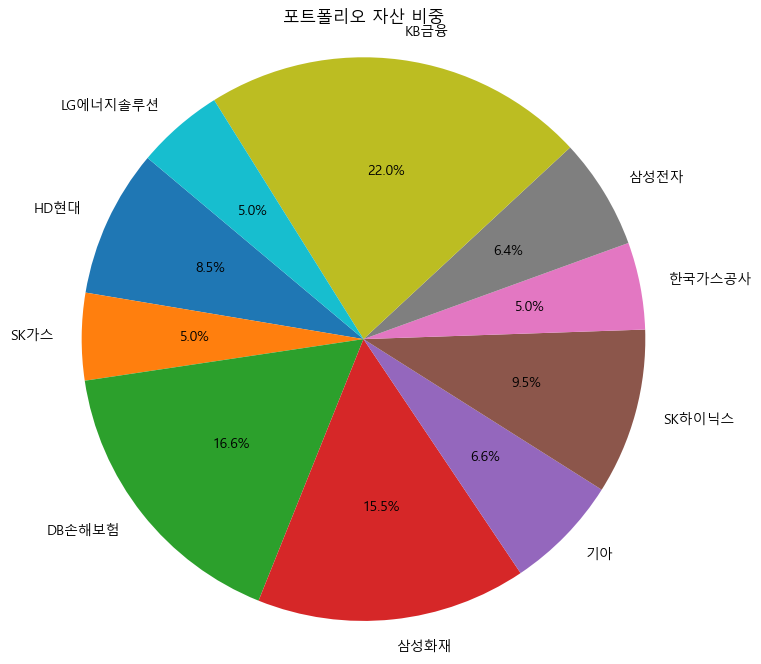

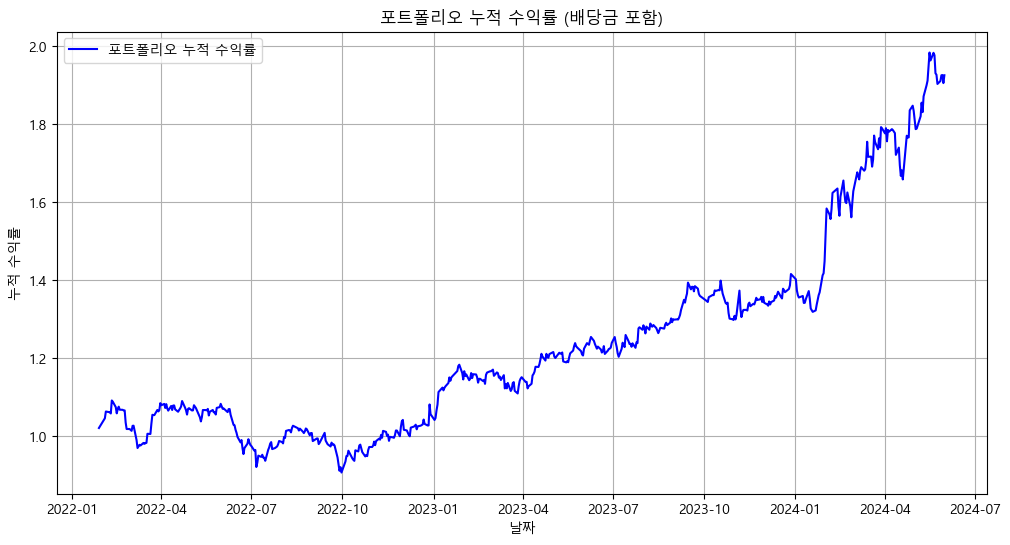

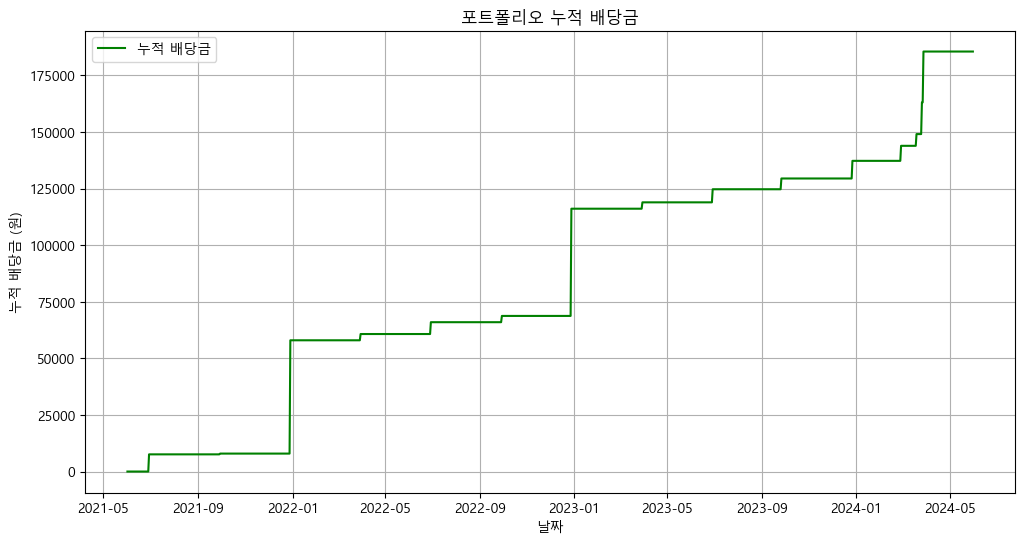

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from datetime import datetime

# 시드 고정 (재현성 확보)
np.random.seed(42)
tf.random.set_seed(42)

# 자산 리스트 및 회사명 정의
asset_info = [
    {"ticker": "267250.KS", "name": "HD현대"},
    {"ticker": "018670.KS", "name": "SK가스"},
    {"ticker": "005830.KS", "name": "DB손해보험"},
    {"ticker": "000810.KS", "name": "삼성화재"},
    {"ticker": "000270.KS", "name": "기아"},
    {"ticker": "000660.KS", "name": "SK하이닉스"},
    {"ticker": "036460.KS", "name": "한국가스공사"},
    {"ticker": "005930.KS", "name": "삼성전자"},
    {"ticker": "105560.KS", "name": "KB금융"},
    {"ticker": "373220.KS", "name": "LG에너지솔루션"}
]

asset_list = [asset['ticker'] for asset in asset_info]
asset_names = {asset['ticker']: asset['name'] for asset in asset_info}

# 시작일과 종료일 설정
start_date = '2021-06-01'
end_date = '2024-06-01'

# 초기 투자금액 설정
initial_investment = 1_000_000  # 1,000,000 원

# yfinance를 사용하여 조정 종가 및 배당금 데이터 수집
data = yf.download(asset_list, start=start_date, end=end_date, actions=True)

# 조정 종가 데이터 추출
price_data = data['Adj Close']

# 배당금 데이터 추출
dividend_data = data['Dividends']

# 결측치 보간 및 제거
price_data = price_data.ffill().dropna()

# 배당금 데이터 결측치 0으로 채우기
dividend_data = dividend_data.fillna(0)

# 일일 수익률 계산
returns = price_data.pct_change().dropna()

# 위험 허용도 설정 (0~1, 낮을수록 보수적)
risk_tolerance = 0.6

# 자산별 특징 계산
features = pd.DataFrame(index=asset_list)
features['mean_return'] = returns.mean()
features['volatility'] = returns.std()

# 샤프 비율 계산 (무위험 수익률 0 가정)
features['sharpe_ratio'] = features['mean_return'] / features['volatility']

# 상관관계 평균 계산
correlation = returns.corr()
features['correlation_with_portfolio'] = correlation.mean()

# 결측치 처리
features = features.fillna(0)

# 특징 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
X = features_scaled
y = features['mean_return'].values

# 학습용 및 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 신경망 모델 구축
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=0  # 진행 상황을 보고 싶다면 1로 변경
)

# 전체 자산에 대해 예측 수행
predicted_returns = model.predict(features_scaled).flatten()
features['predicted_return'] = predicted_returns

# 위험 허용도에 따른 가중치 계산
features['adjusted_score'] = (features['predicted_return'] / features['volatility']) * risk_tolerance

# 무한대 및 NaN 처리
features['adjusted_score'] = features['adjusted_score'].replace([np.inf, -np.inf], 0).fillna(0)

# 가중치 정규화 - 음수 값 제거 후 정규화
features['adjusted_score'] = features['adjusted_score'].clip(lower=0)

# 최소 투자 비중 설정 (5%)
min_weight = 0.05
num_assets = len(asset_list)
total_min_weight = min_weight * num_assets
remaining_weight = 1 - total_min_weight

# 가중치 정규화
adjusted_score_sum = features['adjusted_score'].sum()
if adjusted_score_sum > 0:
    features['weight'] = min_weight + (features['adjusted_score'] / adjusted_score_sum) * remaining_weight
else:
    features['weight'] = min_weight

# 가중치가 5% 미만인 경우 조정 (재할당)
features['weight'] = features['weight'].clip(lower=min_weight)

# 가중치 합계 조정
features['weight'] = features['weight'] / features['weight'].sum()

# 배당금 계산
# 각 자산의 투자금액을 계산
investment_per_asset = initial_investment * features['weight']

# 각 자산의 구매한 주식 수 계산 (가장 첫날의 가격 기준)
first_price = price_data.iloc[0]
shares = investment_per_asset / first_price

# 배당금 계산: 배당금 per share * shares
# 배당금 데이터가 각 자산별로 있는지 확인하고, 없으면 0으로 처리
dividend_data = dividend_data.fillna(0)

# Initialize a Series to hold total dividends
total_dividends = pd.Series(0, index=dividend_data.index)

for ticker in asset_list:
    ticker_dividends = dividend_data[ticker] if ticker in dividend_data.columns else 0
    total_dividends += ticker_dividends * shares[ticker]

# 누적 배당금 계산
cumulative_dividends = total_dividends.cumsum()

# 포트폴리오 일일 수익률 계산 (배당금 포함)
# 포트폴리오 수익률 = 주가 수익률 + (일일 배당금 / 초기 투자금)
portfolio_returns = returns.multiply(features['weight'], axis=1).sum(axis=1) + (total_dividends / initial_investment)

# 누적 수익률 계산
cumulative_returns = (1 + portfolio_returns).cumprod()

# 최종 투자금액 계산
final_value_without_dividend = initial_investment * cumulative_returns.iloc[-1]
final_value = final_value_without_dividend + total_dividends.sum()

# 결과 출력
print(f"초기 투자금액: {initial_investment:,.2f} 원")
print(f"만기 투자금액: {final_value:,.2f} 원")
print(f"총 배당금: {total_dividends.sum():,.2f} 원")

# 포트폴리오 가중치 원형 차트
plt.figure(figsize=(8, 8))
labels = [asset_names[ticker] for ticker in asset_list]
weights = features['weight']
plt.pie(weights, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('포트폴리오 자산 비중')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='포트폴리오 누적 수익률', color='b')
plt.title('포트폴리오 누적 수익률 (배당금 포함)')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.grid(True)
plt.show()

# 누적 배당금 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_dividends.index, cumulative_dividends.values, label='누적 배당금', color='g')
plt.title('포트폴리오 누적 배당금')
plt.xlabel('날짜')
plt.ylabel('누적 배당금 (원)')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
dividend_data

Ticker,000270.KS,000660.KS,000810.KS,005830.KS,005930.KS,018670.KS,036460.KS,105560.KS,267250.KS,373220.KS
Date,,,,,,,,,,
2021-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
